In [6]:
import sys
import numpy as np
import threading
import copy

n=20
current_state = (np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)  # matrica stanja u formatu odgovarajucem za visualizer. pocetno stanje nasumicno generisemo, naredne iteracije ce ga menjati
states = [copy.deepcopy(current_state)]                                     # mozemo odmah sacuvati pocetno stanje u nizu stanja. tu cemo nakon svake iteracije dodavati najnovije stanje

reads = [0 for _ in range(n**2)]                                         # brojaci za citanja svake celije
reads_mutex = [threading.Lock() for _ in range(n**2)]                    # muteksi za sinhronizaciju suseda koji menjaju brojace citanja (tacka 1)
update_self = [threading.Semaphore(0) for _ in range(n**2)]              # semafori za budjenje celija za upis svog novog stanja (tacka 1)
total_updates = 0                                                        # brojac za sve celije koje su azurirale svoje stanje (tacka 3)
total_updates_mutex = threading.Lock()                                   # kljuc koji stiti brojac azuriranih celija (tacka 3)
next_iteration = threading.Condition()                                   # uslov za prelazak u sledecu iteraciju (tacka 2)

xx = [1, 1, 1, -1, -1, -1, 0, 0]                                # koordinate za pomeraj do svih 8 suseda
yy = [1, -1, 0, 1, -1, 0, 1, -1]

def live (tid, x, y, steps = 20):
    global total_updates
    for _ in range(steps):
        alive = 0                                                   # alive - brojac zivih suseda
        for move in range (8):                                      # prolazimo kroz sve susede
            x1 = (x + xx[move]) % n
            y1 = (y + yy[move]) % n                                   # koordinate suseda mod-ujemo sa n zbog torus matrice (spojeni krajevi)
            alive += current_state[x1][y1]                            # dodajemo stanje suseda (0 ili 1) na brojac zivih suseda
            nid = x1*n + y1                                           # nid - neighbor id, cell id = x*20 + y da bismo dobili niz indeksa od 0 do 20^2
            reads_mutex[nid].acquire()                                # trazimo pristup za menjanje brojaca citanja te celije
            reads[nid] += 1
            if reads[nid] == 8:                                       # ako je to bio poslednji sused koji je procitao, budimo celiju da se azurira u matrici stanja
                update_self[nid].release()
            reads_mutex[nid].release()       
        cid = x*n+y
        update_self[cid].acquire()                               # kada je procitala susede celija moze da azurira svoje stanje, ali prvo ceka da svi susedi procitaju njeno trenutno stanje
        reads[cid] = 0                                           # resetuje brojac reads na 0 za sledecu iteraciju                                        
        if (alive < 2 or alive > 3):                             # azuriranje stanja celije u odnosu na uslove
            current_state[x][y] = 0
        elif alive == 3:
            current_state[x][y] = 1
        elif alive == 2 and current_state[x][y] == 1:            # ovde je ovo malo i bespotrebna linija jer ako alive = 2, celija ostaje na stanju na kom je bila
            current_state[x][y] = 1

        total_updates_mutex.acquire()                             # mutex za izmenu brojaca azuriranih celija
        total_updates += 1
        if (total_updates == n**2):                               # kada poslednja celija azurira svoje stanje, cuvamo kopiju stanja i sve niti koje su cekale mogu u sledecu iteraciju
            total_updates = 0
            states.append(copy.deepcopy(current_state))
            total_updates_mutex.release()
            next_iteration.acquire()
            next_iteration.notify_all()
        else:                                                   
            total_updates_mutex.release()                           # ovde je vazno prvo osloboditi mutex za brojac azuriranih celija pa tek onda uci u stanje cekanja za pocetak sledece iteracije                                                          
            next_iteration.acquire()                                # da ne bi doslo do deadlock-a - nit ceka na uslov a drzi kljuc koji treba ostalim nitima da bi ostvarile taj uslov
            next_iteration.wait()
        next_iteration.release()


threads = []
for cid in range(n**2):
    threads.append(threading.Thread(target = live, args = (cid, cid//n, cid%n)))        # od cell id generisemo koordinate - row = index / columns_per_row, column = index % columns_per_row

for t in threads:
    t.start()
    
for t in threads:
    t.join()



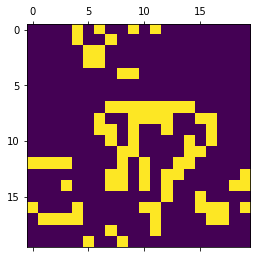

In [7]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


anim = animate(states);
HTML(anim.to_html5_video())